In [1]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
CUDA status:  True
CUDA memory max alloc:        0 MB


In [2]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models
from unet_wildcat import *

In [3]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [4]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



In [5]:
# Set global properties
num_classes=2
input_size=224
batch_size=16
fold = "fold_INDD119294"
data_dir = "/home/pyushkevich/data/thon2019/exp01/%s" % (fold,)
model_dir="/home/pyushkevich/resnet/thon2019/exp01/%s" % (fold,)

In [6]:
# Read the model
model_ft = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
# model_ft=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.05, kmin=0.02, alpha=0.5, num_maps=2)
model_ft.load_state_dict(torch.load(os.path.join(model_dir, "model_%s_wcu_50_15epoch.dat" % (fold,))))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [7]:
# Create a data loader
dt = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

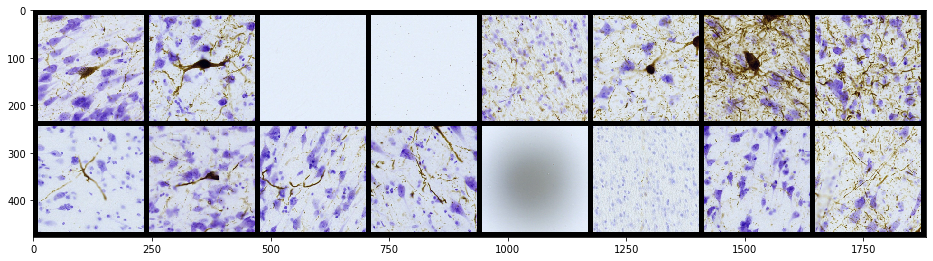

In [8]:

# Read a batch of data
img,label,paths=next(iter(dl))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))

In [9]:
# Evaluate model on this batch
model_ft.eval()
img_d = img.to(device)
label_d = label.to(device)
outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)

(tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]))

## Evaluate Model Accuracy on Test Set

In [10]:
# Perform full test set evaluation and save examples of errors
cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
path_fp = []
path_fn = []
with torch.no_grad():
    for img,label,paths in dl:
        img_d = img.to(device)
        label_d = label.to(device)
        outputs = model_ft(img_d)
        _, preds = torch.max(outputs, 1)
        for a in range(0,len(label)):
            l_pred = preds.cpu()[a].item()
            l_true = label[a].item()
            cm[l_pred,l_true]=cm[l_pred,l_true]+1
            if l_pred == 1 and l_true == 0:
                # False positive (non-tangle classified as tangle)
                img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
                path_fp.append(paths[a]) 
            elif l_pred == 0 and l_true == 1:
                # False negative (tangle classified as non-tangle)
                img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
                path_fn.append(paths[a]) 

# Print confusion matrix
cm

array([[982.,   6.],
       [ 18., 538.]])

Accuracy of the model on the test set

In [11]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9844559585492227

['/home/pyushkevich/data/thon2019/all_patches/7754.png',
 '/home/pyushkevich/data/thon2019/all_patches/11087.png',
 '/home/pyushkevich/data/thon2019/all_patches/10861.png',
 '/home/pyushkevich/data/thon2019/all_patches/8899.png',
 '/home/pyushkevich/data/thon2019/all_patches/10875.png',
 '/home/pyushkevich/data/thon2019/all_patches/10579.png',
 '/home/pyushkevich/data/thon2019/all_patches/10699.png',
 '/home/pyushkevich/data/thon2019/all_patches/9262.png',
 '/home/pyushkevich/data/thon2019/all_patches/10772.png',
 '/home/pyushkevich/data/thon2019/all_patches/9179.png',
 '/home/pyushkevich/data/thon2019/all_patches/7136.png',
 '/home/pyushkevich/data/thon2019/all_patches/7939.png',
 '/home/pyushkevich/data/thon2019/all_patches/9425.png',
 '/home/pyushkevich/data/thon2019/all_patches/11587.png',
 '/home/pyushkevich/data/thon2019/all_patches/11566.png',
 '/home/pyushkevich/data/thon2019/all_patches/10414.png',
 '/home/pyushkevich/data/thon2019/all_patches/10032.png',
 '/home/pyushkevich/d

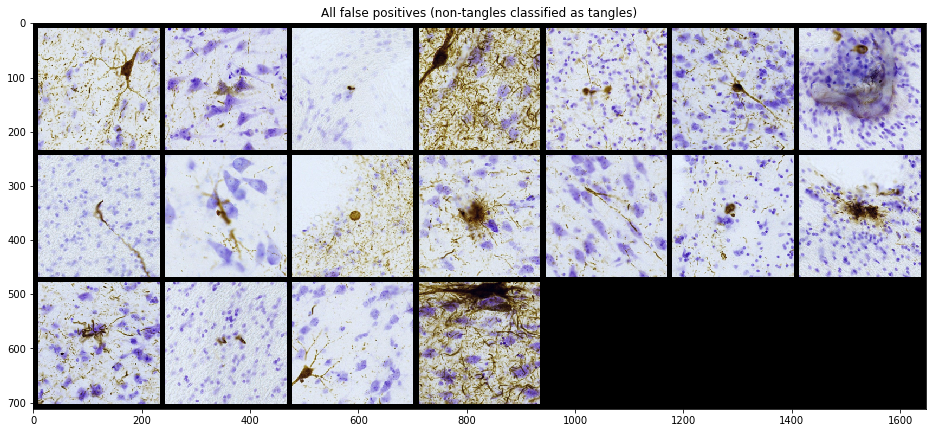

In [12]:
# Plot the false positives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fp, padding=10, nrow=7, normalize=True))
plt.title("All false positives (non-tangles classified as tangles)");
list(map(os.path.realpath, path_fp))

['/home/pyushkevich/data/thon2019/all_patches/11289.png',
 '/home/pyushkevich/data/thon2019/all_patches/7474.png',
 '/home/pyushkevich/data/thon2019/all_patches/8789.png',
 '/home/pyushkevich/data/thon2019/all_patches/11701.png',
 '/home/pyushkevich/data/thon2019/all_patches/10639.png',
 '/home/pyushkevich/data/thon2019/all_patches/11488.png']

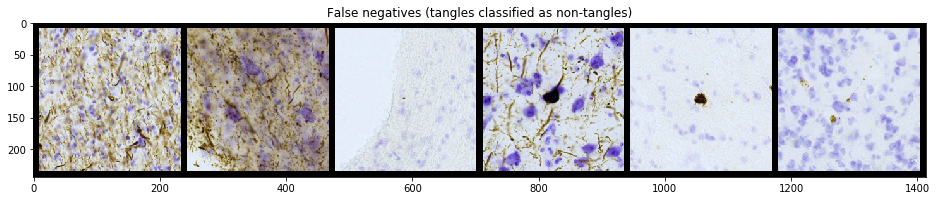

In [13]:
# Plot the false negatives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fn, padding=10, nrow=7, normalize=True))
plt.title("False negatives (tangles classified as non-tangles)");
list(map(os.path.realpath, path_fn))

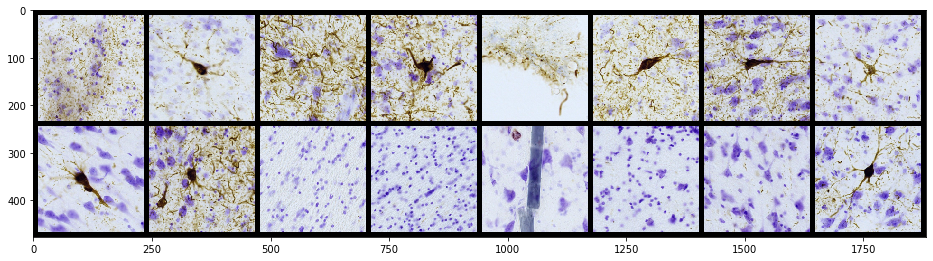

In [14]:
# Read a batch of data again
img,label,paths=next(iter(dl))
img_d = img.to(device)
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))

In [15]:

# Do a manual forward run of the model
x_clas = model_ft.forward_to_classifier(img_d)
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)
x_spool = model_ft.spatial_pooling.spatial(x_cpool)
x_cpool.shape



torch.Size([16, 2, 112, 112])

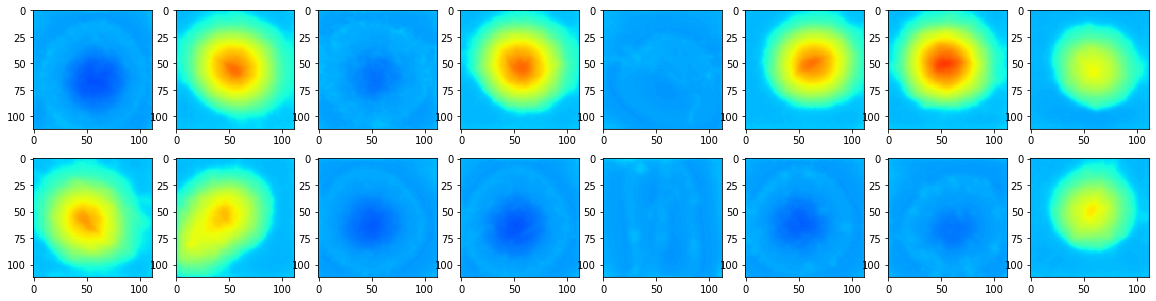

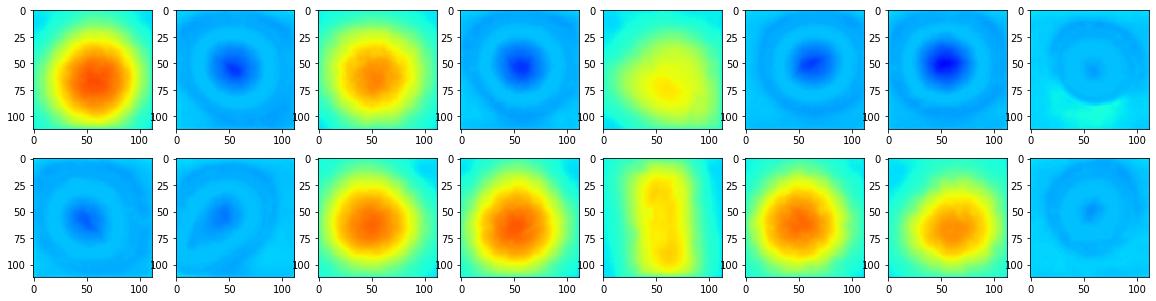

In [16]:
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(x_cpool[i,1,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(x_cpool[i,0,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))




## Experiment with using GMM initialized by heat map to cluster patch

In [155]:
import torch.nn.functional as F

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


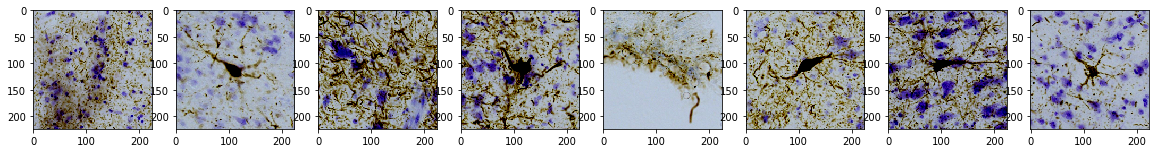

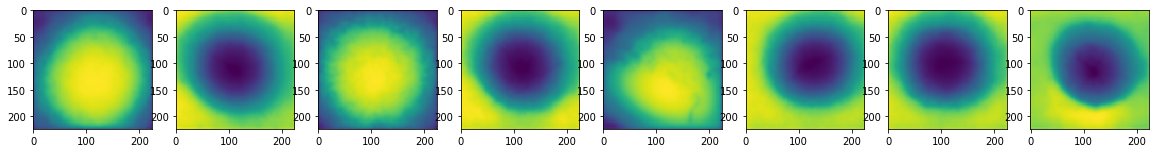

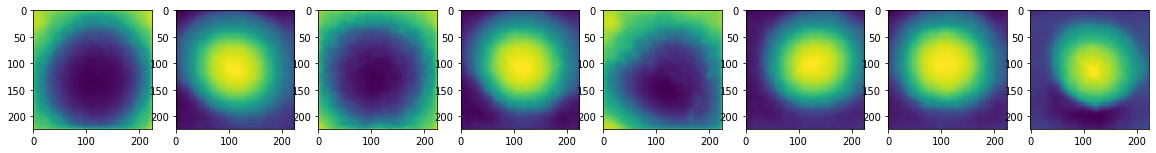

In [303]:
I = img.cuda()
Pij = F.softmax(F.interpolate(x_cpool / 4, img.shape[-2:]),1)
Pij_init = Pij.clone()

plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(I[i,:,:].permute(1,2,0).cpu().detach().numpy() * 0.333)
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(Pij[i,0,:,:].cpu().detach().numpy())
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(Pij[i,1,:,:].cpu().detach().numpy())

In [316]:
# Estimate the Gaussian parameters given Pij
N = Pij.shape[2] * Pij.shape[3]
K = Pij.shape[1]
D = I.shape[1]

SPij = torch.sum(Pij, (2,3))
alpha = SPij / N
mu = torch.zeros((I.shape[0], K, D), device=I.device)
sig = torch.zeros((I.shape[0], K, D, D), device=I.device)

# Estimate the parameters
for k in range(K):
    mu[:,k,:] = torch.sum(I * Pij[:,k:k+1,:,:], (2,3)) / SPij[:,k:k+1]
    Iz = (I - mu[:,k,:].unsqueeze(-1).unsqueeze(-1)).permute(0,2,3,1).unsqueeze(-1)
    t01 = SPij[:,k:k+1].unsqueeze(-1)
    sig[:,k,:,:] = torch.sum((torch.matmul(Iz, Iz.permute(0,1,2,4,3)) * Pij[:,k:k+1,:,:].permute(0,2,3,1).unsqueeze(-1)),(1,2)) / t01
    
# Update the posteriors
Qij = torch.zeros_like(Pij)
for k in range(K):
    alpha_k = alpha[:,k].unsqueeze(-1).unsqueeze(-1)
    distro = torch.distributions.multivariate_normal.MultivariateNormal(mu[:,k,:], sig[:,k,:,:])
    Qij[:,k,:,:] = alpha_k * torch.exp(distro.log_prob(I.permute(2,3,0,1))).permute(2,0,1)
    
Pij = Qij / Qij.sum(1,keepdim=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: conve

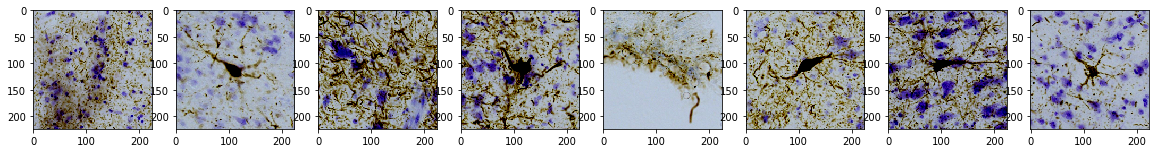

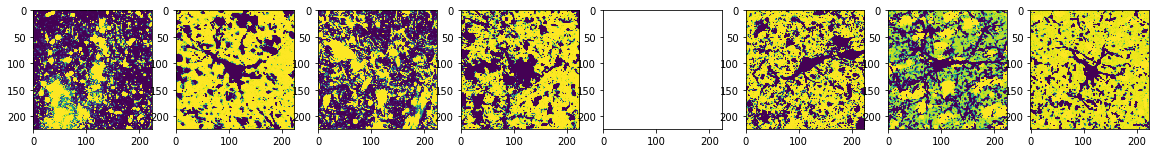

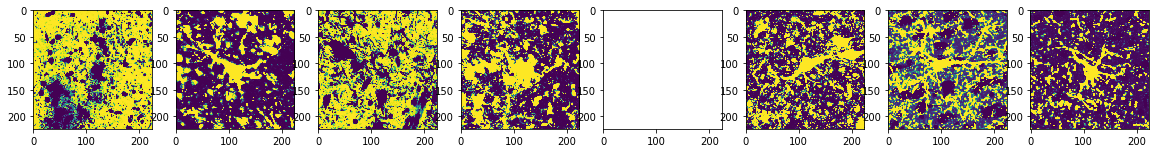

In [317]:
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(I[i,:,:].permute(1,2,0).cpu().detach().numpy() * 0.333)
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(Pij[i,0,:,:].cpu().detach().numpy())
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(Pij[i,1,:,:].cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


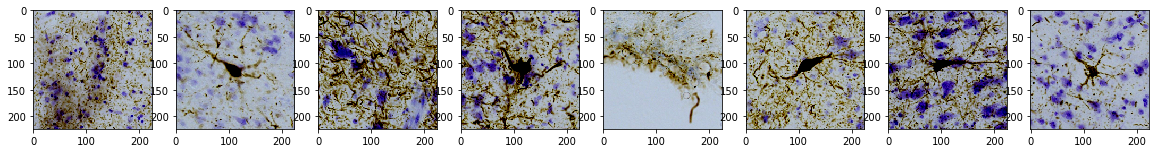

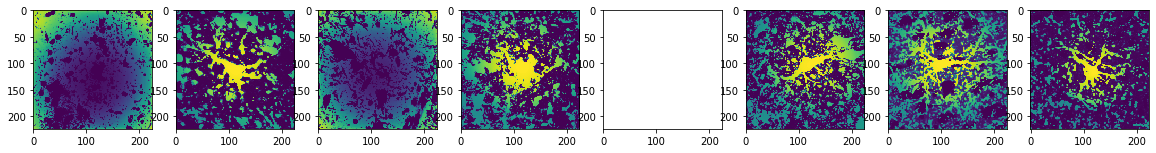

In [320]:
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow(I[i,:,:].permute(1,2,0).cpu().detach().numpy() * 0.333)
plt.figure(figsize=(20,5))
for i in range(0, batch_size//2):
    plt.subplot(1, batch_size//2, i+1)
    plt.imshow((Pij[i,1,:,:]*Pij_init[i,1,:,:]).cpu().detach().numpy())

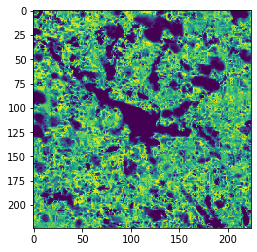

In [237]:
plt.imshow(PPP1[1,:,:].detach().cpu())

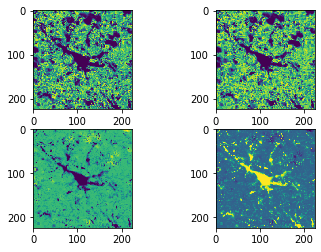

In [223]:
plt.subplot(2,2,1)
plt.imshow(PP1.detach().cpu())
plt.subplot(2,2,2)
plt.imshow(PP2.detach().cpu())
plt.subplot(2,2,3)
plt.imshow((PP1 / (PP1+PP2)).detach().cpu())
plt.subplot(2,2,4)
plt.imshow((PP2 / (PP1+PP2)).detach().cpu())

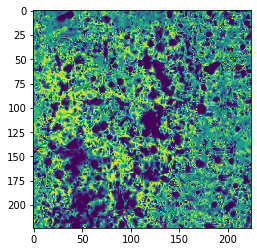

In [175]:
Qij = torch.zeros_like(Pij)
for k in range(K):
    dI = (I - mu[:,k,:].unsqueeze(-1).unsqueeze(-1)).permute(0,2,3,1).unsqueeze(-1)
    JJ = torch.matmul(sig[:,k,:,:].unsqueeze(-1).unsqueeze(-1).permute(0,3,4,1,2), dI)
    Qij[:,k,:,:] = torch.exp(-0.5 * torch.matmul(torch.transpose(dI,3,4),JJ).squeeze()) / torch.sqrt(torch.linalg.det(sig[:,k,:,:])).unsqueeze(-1).unsqueeze(-1)

ssQij = torch.sum(Pij, (1)).unsqueeze(-1).permute(0,3,1,2)    
Qij.shape, ssQij.shape
Pij = (Qij / ssQij)
    

In [177]:
Pij.shape

torch.Size([16, 2, 224, 224])

In [164]:
dI = (I - mu[:,0,:].unsqueeze(-1).unsqueeze(-1)).permute(0,2,3,1).unsqueeze(-1)
dI.shape,sig[:,0,:,:].unsqueeze(-1).unsqueeze(-1).permute(0,3,4,1,2).shape
JJ = torch.matmul(sig[:,0,:,:].unsqueeze(-1).unsqueeze(-1).permute(0,3,4,1,2), dI)
JJ.shape, dI.shape
UU = torch.exp(-0.5 * torch.matmul(torch.transpose(dI,3,4),JJ).squeeze()) / torch.sqrt(torch.linalg.det(sig[:,0,:,:])).unsqueeze(-1).unsqueeze(-1)
UU.shape

torch.Size([16, 224, 224])

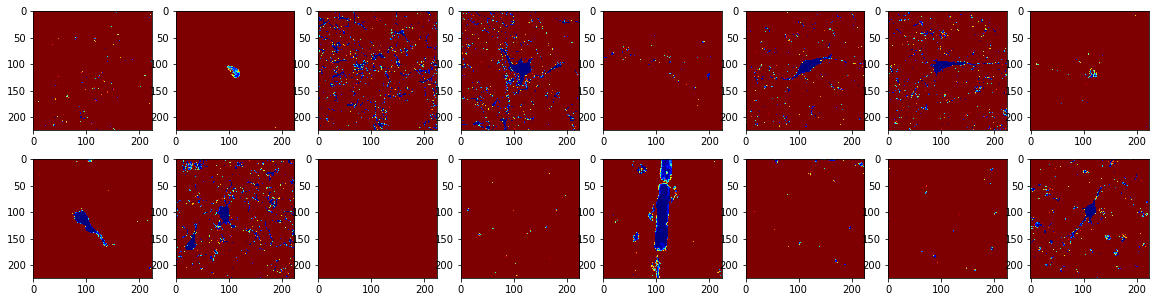

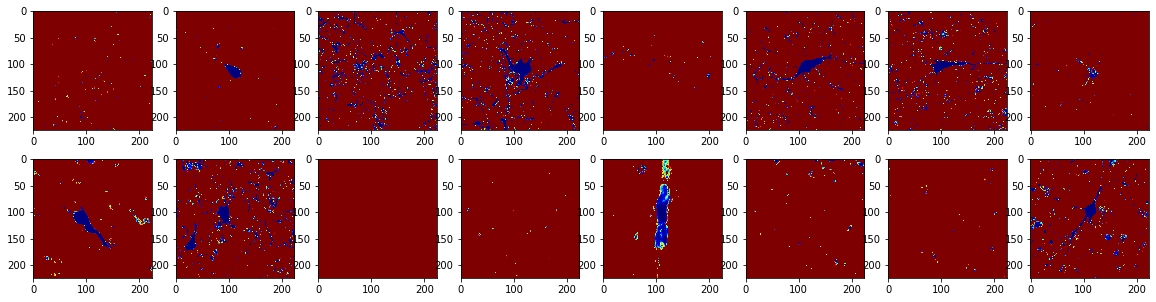

In [181]:
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(Pij[i,0,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))
    
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(Pij[i,1,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))

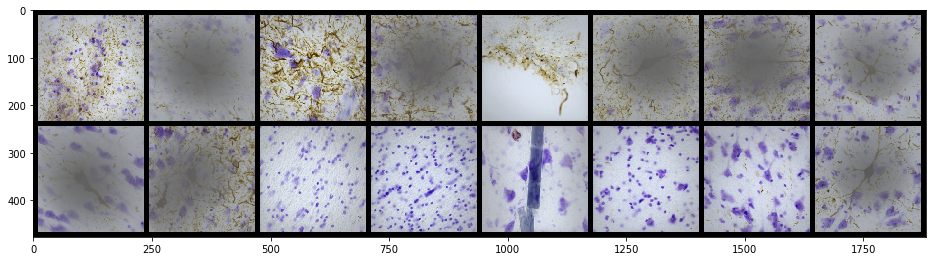

In [145]:
IP = I * Pij[:,0:1,:,:];
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(IP.detach().cpu(), padding=10, nrow=8, normalize=True))

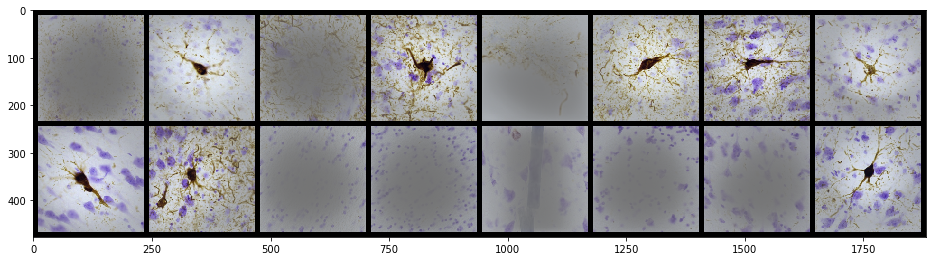

In [76]:
IP = I * Pij[:,1:2,:,:];
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(IP.detach().cpu(), padding=10, nrow=8, normalize=True))

In [78]:
mu

tensor([[[1.5789, 1.5325, 1.5241],
         [1.6596, 1.6393, 1.6488]],

        [[1.8097, 1.8835, 2.0662],
         [1.7697, 1.8287, 1.9596]],

        [[1.3859, 1.2997, 1.0812],
         [1.4126, 1.3362, 1.1304]],

        [[1.5472, 1.4937, 1.4085],
         [1.4533, 1.3805, 1.2832]],

        [[1.9622, 2.0491, 2.0493],
         [1.9660, 2.0579, 2.0650]],

        [[1.7653, 1.7577, 1.5698],
         [1.6934, 1.6667, 1.4605]],

        [[1.3589, 1.2875, 1.4485],
         [1.3045, 1.2216, 1.3506]],

        [[1.7288, 1.7607, 2.0478],
         [1.7153, 1.7407, 1.9832]],

        [[1.6310, 1.6326, 2.1176],
         [1.5725, 1.5599, 1.9805]],

        [[1.2970, 1.1893, 1.1480],
         [1.2423, 1.1260, 1.1079]],

        [[1.8295, 1.9007, 2.2281],
         [1.8246, 1.8938, 2.2210]],

        [[1.5836, 1.6412, 2.1806],
         [1.5607, 1.6117, 2.1779]],

        [[1.5466, 1.5934, 2.0570],
         [1.7089, 1.7509, 2.1774]],

        [[1.6662, 1.7075, 2.2125],
         [1.6213, 1.6479, 2.1

## Older code for CRF (not successful)

In [ ]:
# Import the convcrf package
sys.path.append("/home/pyushkevich/resnet/convcrf")
from convcrf import convcrf


# ConvCRF configuration
config = convcrf.default_conf
config['filter_size'] = 7
config['col_feats']['schan'] = 0.1

In [ ]:
# Upsample the wildcat saliency maps to the image size
unary=nn.functional.interpolate(x_cpool, size=img_d.shape[2:], mode="bilinear", align_corners=False)

# Transform the saliency maps to [0 1] range via sigmoid function
unary[:,1,:,:] = torch.sigmoid((unary[:,1,:,:]-4) / 4.0)
unary[:,0,:,:] = 1 - unary[:,1,:,:];

# Plot the unaries
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(unary[i,0,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(unary[i,1,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))



In [ ]:
# Create the Convolutional CRF
config = convcrf.default_conf
config['filter_size'] = 7
config['col_feats']['schan'] = 0.1
#config['blur']=1
#config['weight_init'] = 0.001
#config['unary_weight'] = 0.01

gausscrf = convcrf.GaussCRF(conf=config, shape=(img_d.shape[2],img_d.shape[3]), nclasses=2)
gausscrf.cuda()
prediction = gausscrf.forward(unary=unary, img=img_d)
prediction_hard = torch.argmax(prediction, dim=1)


In [ ]:
# Plot the prediction
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
plt.figure(figsize=(20,6))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow((prediction[i,1,:,:]-prediction[i,0,:,:]).cpu().detach().numpy(),cmap=plt.get_cmap('jet'),
              vmin=-20, vmax=20)




In [ ]:
config = convcrf.default_conf



import importlib
importlib.reload(convcrf)


config


from IPython.display import Image
Image(filename='convcrf/img.png') 